In [1]:
import skorch
import torch
import torch.nn as nn

from math import ceil
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from sine_data import train_dataset, valid_dataset

In [4]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=200)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [58]:
class ClipBPTTWrapper(nn.Module):
    def __init__(self, rnn_layer, hidden_dim, timestep_divisor):
        super().__init__()
        self.rnn_layer = rnn_layer
        self.hidden_dim = hidden_dim
        self.timestep_divisor = timestep_divisor
        
    def init_hidden(self, batch_size, use_cuda):
        v = Variable(torch.zeros(self.hidden_dim, batch_size, self.hidden_dim))
        return v.cuda() if use_cuda else v
    
    def repack(self, h):
        v = Variable(h.data)
        return v.cuda() if h.is_cuda else v
    
    def rnn(self, x, h):
        return self.rnn_layer(x, h)
        
    def forward(self, x):
        num_steps = ceil(x.size(1) / self.timestep_divisor)
        chunks = torch.chunk(x, num_steps, dim=1)
        h = self.init_hidden(x.size(0), x.is_cuda)
        ys = []
        
        for chunk in chunks:
            h = self.repack(h) # limit backprop to one chunk
            y, h = self.rnn(chunk, h)
            ys.append(y[:,-1])
        return torch.stack(ys, dim=1), h

In [59]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [60]:
class RepeatingRNN(nn.Module):
    def __init__(self, rnn_layer):
        super().__init__()
        self.rnn_layer = rnn_layer
        
    def forward(self, x, target_length):
        repeats = ceil(target_length / x.size(1))
                
        parts = []
        for ti in range(x.size(1)):
            xr = x[:, ti:(ti+1)].repeat(1, repeats, 1)
            parts.append(xr)
        
        x_rep = torch.cat(parts, dim=1)
        y, h = self.rnn_layer(x_rep)
        return y[:, :target_length], h

In [61]:
class ContextDecoderRNN(nn.Module):
    def __init__(self, rnn_layer):
        super().__init__()
        self.rnn_layer = rnn_layer
        
    def forward(self, x, target_length):
        # at time-step target_length % x.size(1) switch context to next value from x
        cidx = 0
        h = x[:, cidx:(cidx+1)].transpose(0, 1) # make context (t, b, u)
        y_tm1 = Variable(torch.zeros(x.size(0), 1, x.size(-1)))
        y_tm1 = y_tm1.cuda() if x.is_cuda else y_tm1
        ys = []
        # every nth step an update happens
        update_step = ceil(target_length / x.size(1))
        for ti in range(target_length):
            y, h_new = self.rnn_layer(y_tm1, h)
            ys.append(y)
            y_tm1 = y
            if ti > 0 and ti % update_step == 0:
                h = x[:, cidx:(cidx+1)].transpose(0, 1)
                cidx += 1
            else:
                h = y_tm1.transpose(0, 1)
        return torch.stack(ys, dim=1), h

In [69]:
class ReconModel(nn.Module):
    def __init__(
        self, 
        num_hidden=16, 
        timestep_divisor_0=20, 
        timestep_divisor_1=2, 
        baseline=False,
    ):
        super().__init__()
        
        # t -> ceil(t/20) timesteps
        layer_0 = nn.GRU(1, num_hidden, batch_first=True)
        self.rnn_enc_0 = ClipBPTTWrapper(layer_0, num_hidden, timestep_divisor_0)
        
        # ceil(t/20) -> ceil(ceil(t/20)/2) timesteps
        layer_1 = nn.GRU(num_hidden, num_hidden, batch_first=True)
        self.rnn_enc_1 = ClipBPTTWrapper(layer_1, num_hidden, timestep_divisor_1)
        
        # ceil(ceil(t/20)/2) chunks total as hidden repr. (3 for t=100)
        # so we now want 3 -> 100 again (recon task)
        # we do this by generating 100//3 for each chunk
        layer_2 = nn.GRU(num_hidden, num_hidden, batch_first=True)
        self.rnn_dec_1 = RepeatingRNN(layer_2)
        #elf.rnn_dec_1 = ContextDecoderRNN(layer_2)

        
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        l0, h0 = self.rnn_enc_0(x)
        l1, h1 = self.rnn_enc_1(l0)
        l2, h2 = self.rnn_dec_1(l1, x.size(1))
        print('l0', l0.size(), 'l1', l1.size(), 'l2', l2.size())
        clf = self.clf(l2)
        return time_unflatten(clf, x.size())

In [70]:
class Trainer(skorch.NeuralNet):
    def __init__(self, 
                 criterion=nn.MSELoss,
                 *args, 
                 **kwargs):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)

## with clip

In [80]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_with = Trainer(module=ReconModel,
             optimizer=torch.optim.Adam,
             lr=0.005,
             max_epochs=160,
             train_split=my_train_split,
             
             module__num_hidden=16,
             module__timestep_divisor_0=4,
             module__timestep_divisor_1=5,
            )

In [81]:
%pdb on
ef_with.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.9450        1.7476  0.4400
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
      2        1.7779        1.6030  0.3796
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
      3        1.6281        1.4586  0.4460
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
      4        1.4782        1.3076  0.4127
l0 torch.Size([5, 50, 16]) l1 torch.Siz

l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
     37        0.1708        0.1946  0.4492
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
     38        0.1790        0.2016  0.4494
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
     39        0.1851        0.1998  0.4280
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
     40        0.1841        0.1898  0.5114
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
     41        0.1762        0.1756  0.4240
l0 torch.Size([5, 50, 16]) l1 torch.Size([

l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
     75        0.0754        0.0698  0.3850
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
     76        0.0747        0.0688  0.4468
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
     77        0.0742        0.0680  0.4382
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
     78        0.0736        0.0671  0.3850
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
    

l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
    111        0.0574        0.0497  0.4454
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
    112        0.0570        0.0494  0.3858
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
    113        0.0567        0.0490  0.4339
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
    114        0.0563        0.0485  0.3800
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
    115        0.0560        0.0481  0.4502
l0 torch.Size([5, 50, 16]) l1 torch.Size([

l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
    148        0.0461        0.0357  0.3873
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
    149        0.0459        0.0353  0.4515
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
    150        0.0456        0.0349  0.3847
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
    151        0.0453        0.0346  0.4336
l0 torch.Size([5, 50, 16]) l1 torch.Size([5, 10, 16]) l2 torch.Size([5, 199, 16])
l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 199, 16])
    

l0 torch.Size([3, 50, 16]) l1 torch.Size([3, 10, 16]) l2 torch.Size([3, 200, 16])


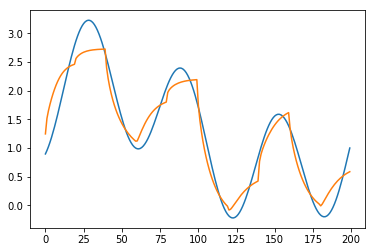

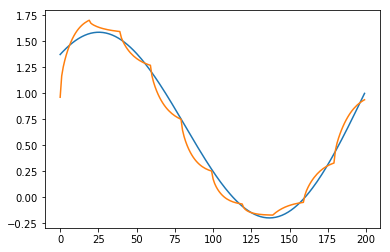

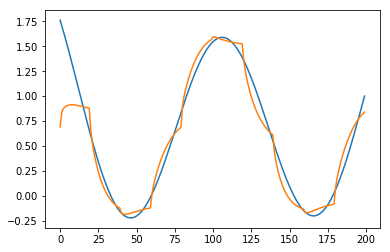

In [82]:
data = X_valid
pred = ef_with.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])